### How to use **`raw_estimate()`**

In [1]:
import math
import ffsim
from passive_extended_matchgate_simulator.raw_estimation import raw_estimate
from passive_extended_matchgate_simulator.exact import exact_calculation
from passive_extended_matchgate_simulator.utils import ucj_to_compatible
from qiskit.circuit import QuantumCircuit, QuantumRegister

#### We'll create a circuit that has 12 qubits and 16 controlled-phase gates. Our matchgates will be initialized randomly, but our controlled-phase gate angles will be sampled from  $\sim \mathcal{N}(0, .1)$.

In [2]:
mean, var = 0, .1
norb, nelec = 6, (3,3)

alpha_alpha_indices = [(p, p + 1) for p in range(norb - 1)]
alpha_beta_indices = [(p, p) for p in range(norb)]

qubits = QuantumRegister(2 * norb)
circuit = QuantumCircuit(qubits)
scale = math.sqrt(var)
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb,
                                                interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
                                                with_final_orbital_rotation=False,
                                                diag_coulomb_mean=mean,
                                                diag_coulomb_scale=scale,
                                                diag_coulomb_normal=True)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

#### We will run this helper function to 1) get rid of any unnecessary global phase gates and 2) make sure that the X gates described by the hartree_fock_jw gate remain at the beginning of the circuit. 

In [3]:
compatible = ucj_to_compatible(circuit)

#### Here is what the circuit looks like when it was been decomposed into just matchgates and controlled-phase gates.

Our circuit contains the following gates:
OrderedDict({'xx_plus_yy': 60, 'p': 24, 'cp': 16, 'x': 6})


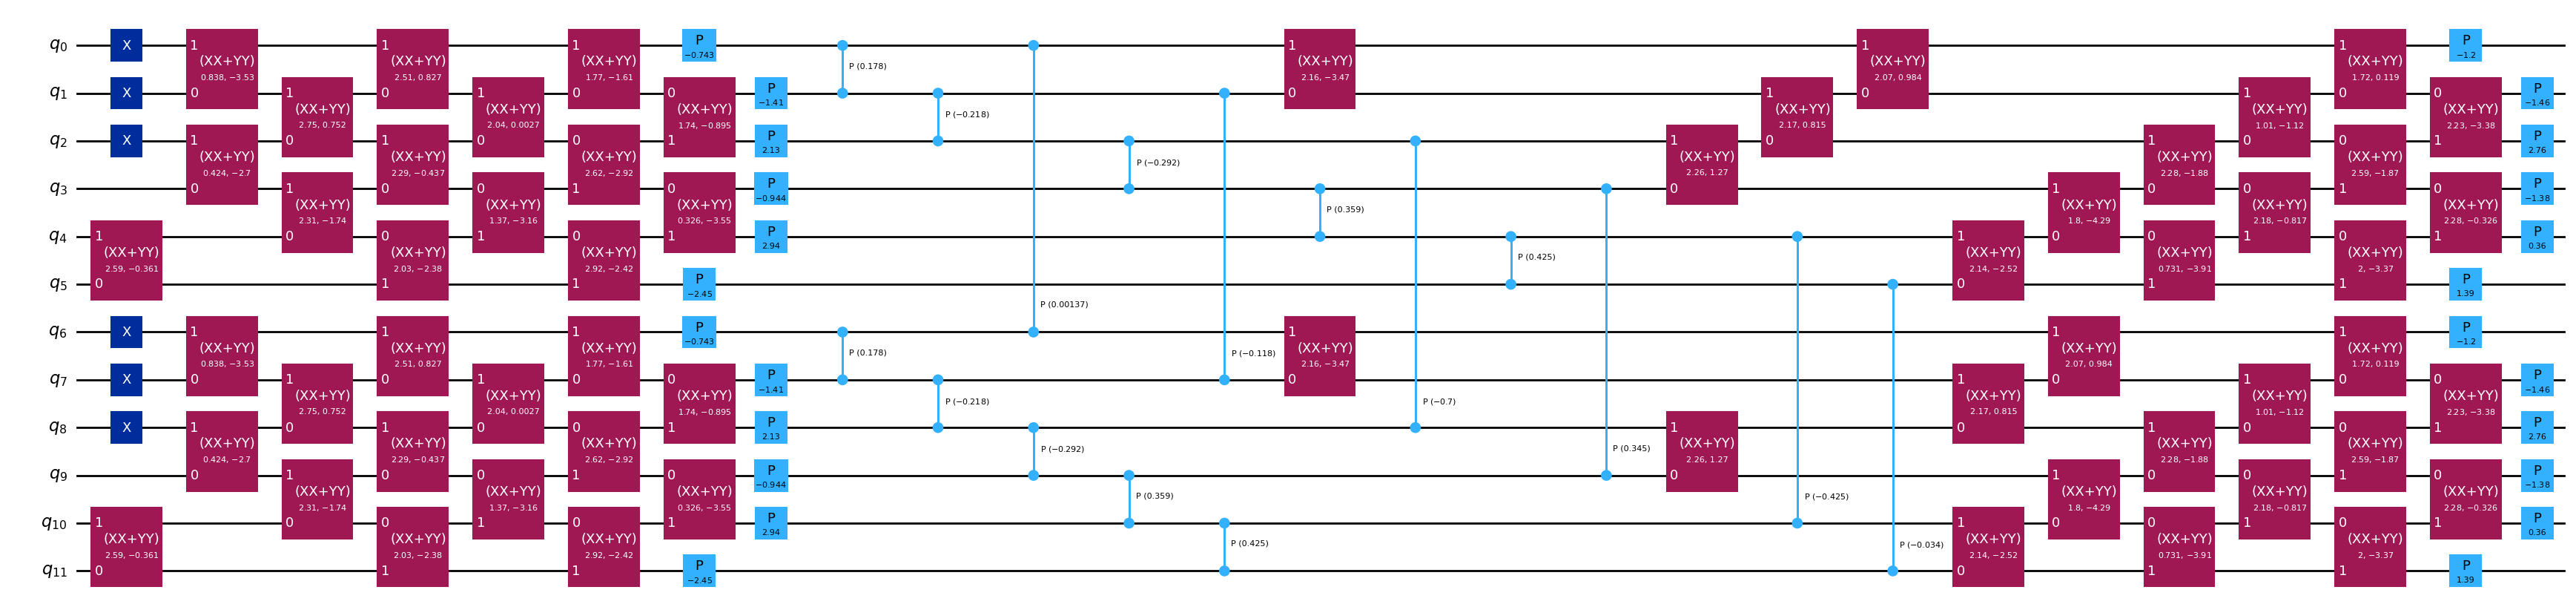

In [4]:
print("Our circuit contains the following gates:")
print(compatible.decompose(gates_to_decompose=['orb_rot_jw']).count_ops())
compatible.decompose(gates_to_decompose=['orb_rot_jw']).draw(fold=-1, output='mpl')

#### Let's estimate the probabilities of 5 arbitrary outcome measurements and compare our results to the exact calculation.

In [5]:
epsilon, delta, p = .1, .01, 1
bitstrings = [
    0b000111000111,
    0b010011000111,
    0b000111001011,
    0b000111100011,
    0b010101000111
]
exact_probs = exact_calculation(circuit=compatible,
                                outcome_states=bitstrings)

raw_estimates = raw_estimate(circuit=compatible,
                             outcome_states=bitstrings,
                             epsilon=epsilon,
                             delta=delta,
                             p=p)

print("Largest difference between any one of our estimates and its exact probability:", max(abs(exact_probs - raw_estimates)))

Largest difference between any one of our estimates and its exact probability: 0.003456382267952307


#### Our estimates are well below the $\epsilon = .1$ error threshold.